In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 3
patience_student = 5
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 76
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [15,10,5,3,0]
lmda_list_teacher = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        adversary_output = adv(student_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [20]:
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            adversary_output = adv(teacher_outputs_detached)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                adversary_output_val = adv(teacher_outputs_detached_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizers, optimizera, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        student.train()
        student.to(device)
        if lmda != 0:
            adv.train()
            adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizers.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 

            # Run the adversarial model on concatenated true labels, and predicted labels
            if lmda != 0:
                optimizera.zero_grad()
                studentached = student_outputs.detach()
                with torch.no_grad():
                    adversary_output = adv(studentached)
                adversary_loss = adv_criterion(adversary_output, targets)
                
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()

            optimizers.step()
            if lmda != 0:
                optimizera.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        adv.eval()
        adv.to(device)
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)
                if lmda != 0:
                    val_studentached = val_student_outputs.detach()   

                    val_adversary_output = adv(val_studentached)
                    val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                    
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                    
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epoch}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.61it/s]


*****Epoch 1/100*****
*****Train Loss:  1.587511 Val Loss:  1.187582*****
*****Validation Accuracy: 62.86%*****
*****Total Avg Disparity: 0.16684844110610364*****

Class Team_Sports: Recall Difference = 0.1291411222047062
Class Celebration: Recall Difference = -0.1518597129573479
Class Parade: Recall Difference = 0.10147719974309566
Class Waiter_Or_Waitress: Recall Difference = -0.2009419152276294
Class Individual_Sports: Recall Difference = -0.16443566673981402
Class Surgeons: Recall Difference = -0.13008130081300806
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.2245087780490641
Class Business: Recall Difference = 0.004262574595055468
Class Dresses: Recall Difference = -0.554601226993865
Class Water Activities: Recall Difference = 0.06501582994120292
Class Picnic: Recall Difference = -0.23529411764705882
Class Rescue: Recall Difference = 0.020506329113924054
Class Cheering: Recall Difference = 0.03314238952536824
Class Performance_And_E

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.58it/s]


*****Epoch 2/100*****
*****Train Loss:  0.842100 Val Loss:  1.162221*****
*****Validation Accuracy: 65.08%*****
*****Total Avg Disparity: 0.13805017304359432*****

Class Team_Sports: Recall Difference = 0.06791615577742771
Class Celebration: Recall Difference = -0.05467960380028292
Class Parade: Recall Difference = 0.03655047585683424
Class Waiter_Or_Waitress: Recall Difference = -0.2417582417582418
Class Individual_Sports: Recall Difference = -0.019091507570770272
Class Surgeons: Recall Difference = -0.16038433111603867
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.16870131380072073
Class Business: Recall Difference = 0.047953964194373366
Class Dresses: Recall Difference = -0.5282208588957056
Class Water Activities: Recall Difference = 0.08706467661691553
Class Picnic: Recall Difference = -0.16339869281045744
Class Rescue: Recall Difference = -0.08683544303797464
Class Cheering: Recall Difference = -0.08694762684124391
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.59it/s]


*****Epoch 3/100*****
*****Train Loss:  0.423300 Val Loss:  1.335411*****
*****Validation Accuracy: 63.32%*****
*****Total Avg Disparity: 0.10985936457812995*****

Class Team_Sports: Recall Difference = 0.013312313890348482
Class Celebration: Recall Difference = -0.06802102284212658
Class Parade: Recall Difference = 0.022070415133998877
Class Waiter_Or_Waitress: Recall Difference = -0.15698587127158536
Class Individual_Sports: Recall Difference = -0.0833516202179797
Class Surgeons: Recall Difference = -0.03843311160384322
Class Spa: Recall Difference = 0.049645390070921946
Class Law_Enforcement: Recall Difference = 0.07917683990233704
Class Business: Recall Difference = -0.08482523444160267
Class Dresses: Recall Difference = -0.6993865030674846
Class Water Activities: Recall Difference = 0.06456354590682967
Class Picnic: Recall Difference = -0.215686274509804
Class Rescue: Recall Difference = -0.029620253164556964
Class Cheering: Recall Difference = 0.09840425531914887
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.52it/s]


*****Epoch 4/100*****
*****Train Loss:  0.226362 Val Loss:  1.460399*****
*****Validation Accuracy: 63.95%*****
*****Total Avg Disparity: 0.07942519667500281*****

Class Team_Sports: Recall Difference = 0.035814795352367645
Class Celebration: Recall Difference = -0.05382049727107335
Class Parade: Recall Difference = 0.11747533134816379
Class Waiter_Or_Waitress: Recall Difference = 0.0015698587127158659
Class Individual_Sports: Recall Difference = -0.009180016092458554
Class Surgeons: Recall Difference = -0.03917220990391723
Class Spa: Recall Difference = -0.014184397163120477
Class Law_Enforcement: Recall Difference = 0.04859900011626561
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.5975460122699385
Class Water Activities: Recall Difference = 0.026458616010854974
Class Picnic: Recall Difference = -0.2549019607843137
Class Rescue: Recall Difference = -0.03822784810126584
Class Cheering: Recall Difference = -0.009001636661211121
Class Perf

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.61it/s]


*****Epoch 5/100*****
*****Train Loss:  0.146079 Val Loss:  1.558393*****
*****Validation Accuracy: 63.64%*****
*****Total Avg Disparity: 0.11626767060569561*****

Class Team_Sports: Recall Difference = 0.03699421965317917
Class Celebration: Recall Difference = -0.032191227006266365
Class Parade: Recall Difference = 0.04233082267764354
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120894
Class Individual_Sports: Recall Difference = -0.13133640552995374
Class Surgeons: Recall Difference = -0.14855875831485588
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.06720148819904648
Class Business: Recall Difference = -0.0652173913043479
Class Dresses: Recall Difference = -0.4380368098159508
Class Water Activities: Recall Difference = -0.011194029850746245
Class Picnic: Recall Difference = -0.4444444444444444
Class Rescue: Recall Difference = 0.013670886075949351
Class Cheering: Recall Difference = -0.08694762684124385
Class Performa

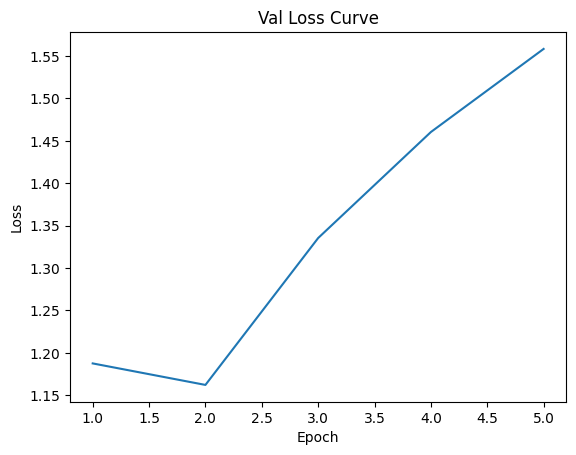

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [21]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
#     teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
#     teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 0: loss - 0.6240541211822453


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 1: loss - 0.37373925504439015


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 2: loss - 0.25004009639515595


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.39745451948221994


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.39751023974488764


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.39758600820513335


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 1/100*****
*****Train Loss: -4.921456 Val Loss: -4.216658*****
*****Validation Accuracy: 62.68%*****
*****Total Avg Disparity: 0.13198563085996176*****

Class Team_Sports: Recall Difference = 0.04193378875459797
Class Celebration: Recall Difference = -0.054325854052961364
Class Parade: Recall Difference = 0.03655047585683413
Class Waiter_Or_Waitress: Recall Difference = -0.29591836734693877
Class Individual_Sports: Recall Difference = -0.1117694389583791
Class Surgeons: Recall Difference = -0.03917220990391723
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.1381234740146493
Class Business: Recall Difference = 0.006606990622335829
Class Dresses: Recall Difference = -0.6932515337423313
Class Water Activities: Recall Difference = 0.003505201266395197
Class Picnic: Recall Difference = -0.2418300653594771
Class Rescue: Recall Difference = 0.04632911392405065
Class Cheering: Recall Difference = 0.002659574468085124
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.42it/s]


*****Epoch 2/100*****
*****Train Loss: -5.357361 Val Loss: -4.218383*****
*****Validation Accuracy: 64.53%*****
*****Total Avg Disparity: 0.14643058015100324*****

Class Team_Sports: Recall Difference = 0.018812401471361095
Class Celebration: Recall Difference = -0.12330705478067505
Class Parade: Recall Difference = 0.052373445437029154
Class Waiter_Or_Waitress: Recall Difference = -0.22919937205651497
Class Individual_Sports: Recall Difference = -0.08916684953551313
Class Surgeons: Recall Difference = -0.05691056910569092
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.10801069643064776
Class Business: Recall Difference = -0.05647911338448419
Class Dresses: Recall Difference = -0.6730061349693252
Class Water Activities: Recall Difference = -0.04194934418815022
Class Picnic: Recall Difference = -0.25490196078431376
Class Rescue: Recall Difference = 0.0736708860759494
Class Cheering: Recall Difference = -0.10576923076923078
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 3/100*****
*****Train Loss: -5.530231 Val Loss: -4.534673*****
*****Validation Accuracy: 64.82%*****
*****Total Avg Disparity: 0.1469765698137407*****

Class Team_Sports: Recall Difference = 0.03895603433175687
Class Celebration: Recall Difference = -0.06296745502324641
Class Parade: Recall Difference = 0.02498978221521575
Class Waiter_Or_Waitress: Recall Difference = -0.2778649921507066
Class Individual_Sports: Recall Difference = -0.02157852388267123
Class Surgeons: Recall Difference = -0.08130081300813019
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.007789791884664554
Class Business: Recall Difference = -0.02941176470588236
Class Dresses: Recall Difference = -0.7300613496932514
Class Water Activities: Recall Difference = -0.03459972862957916
Class Picnic: Recall Difference = -0.14379084967320266
Class Rescue: Recall Difference = 0.1222784810126582
Class Cheering: Recall Difference = -0.06362520458265136
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 4/100*****
*****Train Loss: -5.654199 Val Loss: -4.467146*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.15069105564596164*****

Class Team_Sports: Recall Difference = 0.03783499737256957
Class Celebration: Recall Difference = -0.03795229431978975
Class Parade: Recall Difference = 0.09575524026391091
Class Waiter_Or_Waitress: Recall Difference = -0.24960753532182112
Class Individual_Sports: Recall Difference = -0.045022309999268595
Class Surgeons: Recall Difference = -0.03917220990391723
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.1146378328101384
Class Business: Recall Difference = -0.023870417732310245
Class Dresses: Recall Difference = -0.8098159509202453
Class Water Activities: Recall Difference = -0.04884667571234724
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.04632911392405065
Class Cheering: Recall Difference = -0.054009819967266726
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 5/100*****
*****Train Loss: -5.704683 Val Loss: -4.542828*****
*****Validation Accuracy: 66.20%*****
*****Total Avg Disparity: 0.14872328546786656*****

Class Team_Sports: Recall Difference = 0.0475973608921586
Class Celebration: Recall Difference = 0.01900141499898933
Class Parade: Recall Difference = 0.05535119985987047
Class Waiter_Or_Waitress: Recall Difference = -0.2315541601255886
Class Individual_Sports: Recall Difference = -0.041438080608587446
Class Surgeons: Recall Difference = -0.1426459719142646
Class Spa: Recall Difference = -0.3475177304964538
Class Law_Enforcement: Recall Difference = 0.13056621323101958
Class Business: Recall Difference = 0.026214833759590772
Class Dresses: Recall Difference = -0.7668711656441718
Class Water Activities: Recall Difference = -0.03414744459520558
Class Picnic: Recall Difference = -0.18300653594771238
Class Rescue: Recall Difference = 0.053670886075949276
Class Cheering: Recall Difference = -0.0687397708674305
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 6/100*****
*****Train Loss: -5.711368 Val Loss: -4.440154*****
*****Validation Accuracy: 66.23%*****
*****Total Avg Disparity: 0.1507543989591668*****

Class Team_Sports: Recall Difference = 0.020774216149938796
Class Celebration: Recall Difference = -0.00010107135637760223
Class Parade: Recall Difference = 0.012027792374613155
Class Waiter_Or_Waitress: Recall Difference = -0.2904238618524332
Class Individual_Sports: Recall Difference = -0.01276424548313948
Class Surgeons: Recall Difference = -0.0325203252032521
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.1239390768515286
Class Business: Recall Difference = -0.037936913895993074
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = -0.02657168701944812
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = 0.12430379746835457
Class Cheering: Recall Difference = -0.10372340425531912
Class Perform

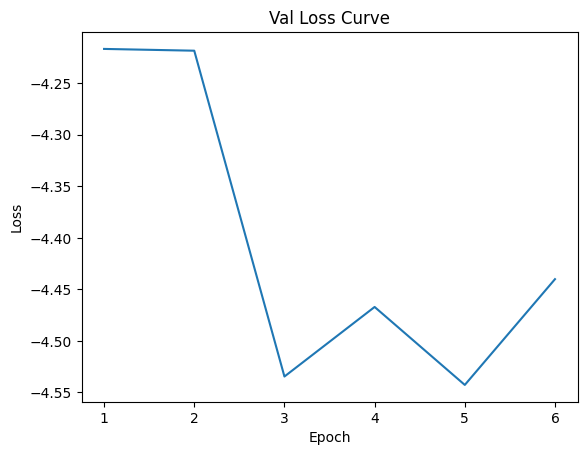

Student weights and architecture saved and exported for lambda: 15


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 0: loss - 0.6316116853233646


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 1: loss - 0.3694701132309787


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 2: loss - 0.24730250009280794


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3932451154379284


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3931807319031042


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3931345019270392


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 1/100*****
*****Train Loss: -2.889246 Val Loss: -2.672407*****
*****Validation Accuracy: 62.25%*****
*****Total Avg Disparity: 0.1511143813805068*****

Class Team_Sports: Recall Difference = 0.07835581245985856
Class Celebration: Recall Difference = 0.030523549626035984
Class Parade: Recall Difference = 0.09575524026391069
Class Waiter_Or_Waitress: Recall Difference = -0.20408163265306123
Class Individual_Sports: Recall Difference = -0.12193694682173939
Class Surgeons: Recall Difference = -0.1359940872135994
Class Spa: Recall Difference = -0.32624113475177313
Class Law_Enforcement: Recall Difference = 0.17974654109987198
Class Business: Recall Difference = -0.06436487638533672
Class Dresses: Recall Difference = -0.6871165644171779
Class Water Activities: Recall Difference = -0.04308005427408412
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = -0.060253164556962
Class Cheering: Recall Difference = 0.004705400981996788
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 2/100*****
*****Train Loss: -3.303486 Val Loss: -2.781138*****
*****Validation Accuracy: 63.49%*****
*****Total Avg Disparity: 0.10676748558384382*****

Class Team_Sports: Recall Difference = 0.028072633852980866
Class Celebration: Recall Difference = -0.02966444309682642
Class Parade: Recall Difference = 0.13621766800957535
Class Waiter_Or_Waitress: Recall Difference = -0.1601255886970172
Class Individual_Sports: Recall Difference = -0.04915514592933945
Class Surgeons: Recall Difference = -0.08795269770879532
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.057900244157656156
Class Business: Recall Difference = -0.035805626598465534
Class Dresses: Recall Difference = -0.6503067484662577
Class Water Activities: Recall Difference = -0.056874717322478396
Class Picnic: Recall Difference = -0.12418300653594772
Class Rescue: Recall Difference = -0.002278481012658262
Class Cheering: Recall Difference = -0.028846153846153855
Class Per

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 3/100*****
*****Train Loss: -3.514382 Val Loss: -2.536909*****
*****Validation Accuracy: 64.39%*****
*****Total Avg Disparity: 0.09764947074588264*****

Class Team_Sports: Recall Difference = 0.04939569101418817
Class Celebration: Recall Difference = -0.03305033353547604
Class Parade: Recall Difference = 0.02790914929643251
Class Waiter_Or_Waitress: Recall Difference = -0.16797488226059654
Class Individual_Sports: Recall Difference = -0.03979226099041766
Class Surgeons: Recall Difference = -0.014781966001478075
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.13324032089291948
Class Business: Recall Difference = -0.02941176470588247
Class Dresses: Recall Difference = -0.5668711656441718
Class Water Activities: Recall Difference = -0.033921302578019064
Class Picnic: Recall Difference = -0.2222222222222222
Class Rescue: Recall Difference = 0.06101265822784807
Class Cheering: Recall Difference = -0.02618657937806873
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 4/100*****
*****Train Loss: -3.521699 Val Loss: -2.691402*****
*****Validation Accuracy: 65.28%*****
*****Total Avg Disparity: 0.11207880865985335*****

Class Team_Sports: Recall Difference = 0.03783499737256957
Class Celebration: Recall Difference = -0.01445320396199723
Class Parade: Recall Difference = 0.07117416944006527
Class Waiter_Or_Waitress: Recall Difference = -0.14992150706436425
Class Individual_Sports: Recall Difference = -0.03620803159973662
Class Surgeons: Recall Difference = -0.014781966001478186
Class Spa: Recall Difference = -0.2624113475177305
Class Law_Enforcement: Recall Difference = 0.17358446692245066
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.6932515337423313
Class Water Activities: Recall Difference = -0.018769787426503814
Class Picnic: Recall Difference = -0.24183006535947715
Class Rescue: Recall Difference = -0.004303797468354464
Class Cheering: Recall Difference = 0.011661211129296245
Class Perfor

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 5/100*****
*****Train Loss: -3.600002 Val Loss: -2.805422*****
*****Validation Accuracy: 65.54%*****
*****Total Avg Disparity: 0.1215190379381079*****

Class Team_Sports: Recall Difference = 0.05079698721317227
Class Celebration: Recall Difference = -0.07868405093996372
Class Parade: Recall Difference = 0.08133356688269988
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497642
Class Individual_Sports: Recall Difference = -0.006144393241167445
Class Surgeons: Recall Difference = -0.11825572801182549
Class Spa: Recall Difference = -0.03546099290780136
Class Law_Enforcement: Recall Difference = 0.11417277060806874
Class Business: Recall Difference = 0.09825234441602726
Class Dresses: Recall Difference = -0.7177914110429447
Class Water Activities: Recall Difference = 0.0032790592492085713
Class Picnic: Recall Difference = -0.24183006535947715
Class Rescue: Recall Difference = 0.02835443037974683
Class Cheering: Recall Difference = -0.07078559738134205
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 6/100*****
*****Train Loss: -3.613971 Val Loss: -2.935931*****
*****Validation Accuracy: 65.48%*****
*****Total Avg Disparity: 0.12244937402178381*****

Class Team_Sports: Recall Difference = 0.01931453260933036
Class Celebration: Recall Difference = 0.006165352739033736
Class Parade: Recall Difference = 0.06399252642027209
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120872
Class Individual_Sports: Recall Difference = -0.02406554019457241
Class Surgeons: Recall Difference = -0.13008130081300817
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.13719334961051044
Class Business: Recall Difference = 0.023017902813299296
Class Dresses: Recall Difference = -0.7361963190184049
Class Water Activities: Recall Difference = 0.03312980551786515
Class Picnic: Recall Difference = -0.33333333333333326
Class Rescue: Recall Difference = 0.025063291139240496
Class Cheering: Recall Difference = -0.04296235679214405
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.40it/s]


*****Epoch 7/100*****
*****Train Loss: -3.641324 Val Loss: -2.815410*****
*****Validation Accuracy: 66.26%*****
*****Total Avg Disparity: 0.11781855746336775*****

Class Team_Sports: Recall Difference = 0.012693408069130663
Class Celebration: Recall Difference = -0.005659995957145669
Class Parade: Recall Difference = 0.05675249605885435
Class Waiter_Or_Waitress: Recall Difference = -0.08555729984301408
Class Individual_Sports: Recall Difference = -0.04004827737546646
Class Surgeons: Recall Difference = 0.04656319290465638
Class Spa: Recall Difference = 0.007092198581560294
Class Law_Enforcement: Recall Difference = 0.12835716777118933
Class Business: Recall Difference = 0.07310315430520031
Class Dresses: Recall Difference = -0.7546012269938651
Class Water Activities: Recall Difference = -0.018769787426503703
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = -0.0075949367088608
Class Cheering: Recall Difference = -0.07283142389525366
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.43it/s]


*****Epoch 8/100*****
*****Train Loss: -3.667701 Val Loss: -2.881786*****
*****Validation Accuracy: 65.66%*****
*****Total Avg Disparity: 0.12036063526932429*****

Class Team_Sports: Recall Difference = 0.018193495650142943
Class Celebration: Recall Difference = -0.053163533454618994
Class Parade: Recall Difference = 0.040871139137034995
Class Waiter_Or_Waitress: Recall Difference = -0.18838304552590257
Class Individual_Sports: Recall Difference = -0.03785385121790641
Class Surgeons: Recall Difference = -0.1359940872135995
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.14742471805603985
Class Business: Recall Difference = -0.021739130434782594
Class Dresses: Recall Difference = -0.6239263803680981
Class Water Activities: Recall Difference = -0.0192220714608774
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = 0.0177215189873417
Class Cheering: Recall Difference = -0.06833060556464815
Class Performa

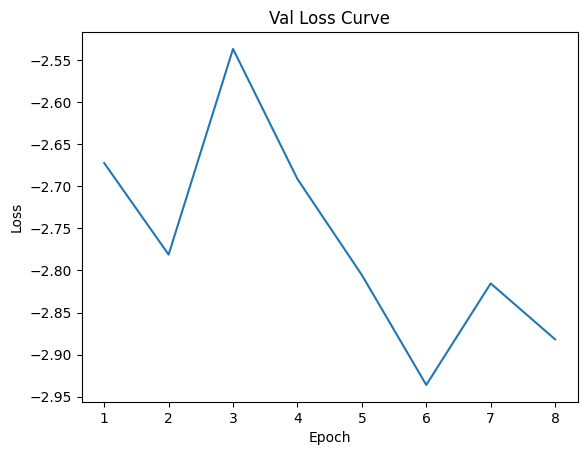

Student weights and architecture saved and exported for lambda: 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 0: loss - 0.6278947611503741


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 1: loss - 0.37808548987788315


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 2: loss - 0.25009973182836


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.46705137609558944


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.46701033698285327


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.46717116149032817


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 1/100*****
*****Train Loss: -1.518123 Val Loss: -1.105923*****
*****Validation Accuracy: 61.62%*****
*****Total Avg Disparity: 0.13945222660555576*****

Class Team_Sports: Recall Difference = 0.03755473813277299
Class Celebration: Recall Difference = -0.10031332120477049
Class Parade: Recall Difference = 0.059671863140071224
Class Waiter_Or_Waitress: Recall Difference = -0.25274725274725274
Class Individual_Sports: Recall Difference = 0.05698193255796957
Class Surgeons: Recall Difference = -0.08203991130820404
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.10487152656667842
Class Business: Recall Difference = -0.07715260017050307
Class Dresses: Recall Difference = -0.6423312883435583
Class Water Activities: Recall Difference = 0.018656716417910335
Class Picnic: Recall Difference = -0.06535947712418305
Class Rescue: Recall Difference = 0.18632911392405055
Class Cheering: Recall Difference = -0.08694762684124391
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 2/100*****
*****Train Loss: -1.819297 Val Loss: -1.218181*****
*****Validation Accuracy: 64.91%*****
*****Total Avg Disparity: 0.16062406446002528*****

Class Team_Sports: Recall Difference = 0.062416068196414876
Class Celebration: Recall Difference = -0.08070547806751566
Class Parade: Recall Difference = 0.039469842938051
Class Waiter_Or_Waitress: Recall Difference = -0.3932496075353217
Class Individual_Sports: Recall Difference = -0.055774998171311485
Class Surgeons: Recall Difference = -0.10643015521064292
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.12440413905359848
Class Business: Recall Difference = -0.10443307757885767
Class Dresses: Recall Difference = -0.7914110429447853
Class Water Activities: Recall Difference = 0.01085481682496603
Class Picnic: Recall Difference = -0.477124183006536
Class Rescue: Recall Difference = -0.021012658227848036
Class Cheering: Recall Difference = -0.060147299509001606
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.41it/s]


*****Epoch 3/100*****
*****Train Loss: -1.985919 Val Loss: -1.288824*****
*****Validation Accuracy: 65.14%*****
*****Total Avg Disparity: 0.13102388302016058*****

Class Team_Sports: Recall Difference = 0.03469375839318045
Class Celebration: Recall Difference = -0.08171619163129168
Class Parade: Recall Difference = 0.08133356688269988
Class Waiter_Or_Waitress: Recall Difference = -0.28806907378335933
Class Individual_Sports: Recall Difference = -0.06294345695267345
Class Surgeons: Recall Difference = 0.033998521803399795
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.07429368678060688
Class Business: Recall Difference = -0.029198635976129594
Class Dresses: Recall Difference = -0.7975460122699385
Class Water Activities: Recall Difference = -0.03414744459520558
Class Picnic: Recall Difference = -0.3529411764705882
Class Rescue: Recall Difference = 0.03569620253164557
Class Cheering: Recall Difference = -0.007978723404255372
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 4/100*****
*****Train Loss: -2.096664 Val Loss: -1.297964*****
*****Validation Accuracy: 65.69%*****
*****Total Avg Disparity: 0.1439905611161628*****

Class Team_Sports: Recall Difference = 0.05713785251357517
Class Celebration: Recall Difference = -0.033707297351930454
Class Parade: Recall Difference = 0.040871139137034995
Class Waiter_Or_Waitress: Recall Difference = -0.3037676609105181
Class Individual_Sports: Recall Difference = -0.06736888303708577
Class Surgeons: Recall Difference = -0.045824094604582366
Class Spa: Recall Difference = 0.07092198581560272
Class Law_Enforcement: Recall Difference = 0.06324845948145574
Class Business: Recall Difference = -0.007459505541347
Class Dresses: Recall Difference = -0.7177914110429447
Class Water Activities: Recall Difference = -0.00407055630936215
Class Picnic: Recall Difference = -0.3464052287581699
Class Rescue: Recall Difference = 0.10430379746835439
Class Cheering: Recall Difference = -0.1421849427168576
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.44it/s]


*****Epoch 5/100*****
*****Train Loss: -2.126987 Val Loss: -1.339542*****
*****Validation Accuracy: 66.00%*****
*****Total Avg Disparity: 0.17454948556851363*****

Class Team_Sports: Recall Difference = 0.03435511181175932
Class Celebration: Recall Difference = -0.03997372144734179
Class Parade: Recall Difference = 0.10007590354411156
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180534
Class Individual_Sports: Recall Difference = -0.0833516202179796
Class Surgeons: Recall Difference = 0.033998521803399906
Class Spa: Recall Difference = -0.41134751773049644
Class Law_Enforcement: Recall Difference = 0.13277525869084994
Class Business: Recall Difference = -0.07161125319693096
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = 0.01843057440072371
Class Picnic: Recall Difference = -0.3529411764705882
Class Rescue: Recall Difference = 0.10430379746835439
Class Cheering: Recall Difference = -0.10270049099836326
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.45it/s]


*****Epoch 6/100*****
*****Train Loss: -2.171266 Val Loss: -1.358489*****
*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.1388258764059656*****

Class Team_Sports: Recall Difference = 0.033514334092368814
Class Celebration: Recall Difference = -0.01445320396199723
Class Parade: Recall Difference = 0.04519180241723597
Class Waiter_Or_Waitress: Recall Difference = -0.26530612244897955
Class Individual_Sports: Recall Difference = -0.010825835710628118
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.07254970352284595
Class Business: Recall Difference = -0.058610400682011954
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = -0.0718000904568068
Class Picnic: Recall Difference = -0.22222222222222227
Class Rescue: Recall Difference = 0.07164556962025309
Class Cheering: Recall Difference = -0.11845335515548283
Class Performa

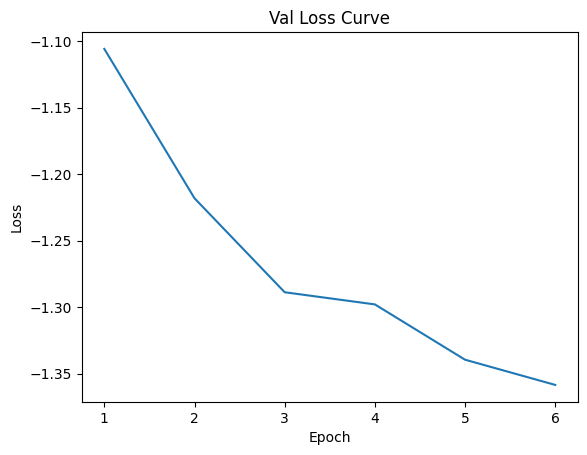

Student weights and architecture saved and exported for lambda: 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.65it/s]


*******Epoch 0: loss - 0.6328513854566742


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 1: loss - 0.3791399747133255


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:22<00:00,  1.64it/s]


*******Epoch 2: loss - 0.24759281700586572


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:41<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.49083854389541287


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.4909882915808874


100%|████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.4909006521544036


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 1/100*****
*****Train Loss: -0.558509 Val Loss: -0.140420*****
*****Validation Accuracy: 60.35%*****
*****Total Avg Disparity: 0.13901363268787575*****

Class Team_Sports: Recall Difference = -0.0020085245518769446
Class Celebration: Recall Difference = -0.05417424701839507
Class Parade: Recall Difference = 0.06399252642027209
Class Waiter_Or_Waitress: Recall Difference = -0.22213500784929352
Class Individual_Sports: Recall Difference = -0.11151342257333052
Class Surgeons: Recall Difference = -0.09977827050997778
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.20323218230438328
Class Business: Recall Difference = 0.010017050298380181
Class Dresses: Recall Difference = -0.6361963190184049
Class Water Activities: Recall Difference = 0.011080958842152988
Class Picnic: Recall Difference = -0.24836601307189543
Class Rescue: Recall Difference = 0.05898734177215187
Class Cheering: Recall Difference = -0.18719312602291316
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 2/100*****
*****Train Loss: -0.898169 Val Loss: -0.497382*****
*****Validation Accuracy: 63.41%*****
*****Total Avg Disparity: 0.1585186902080787*****

Class Team_Sports: Recall Difference = 0.08267647574005965
Class Celebration: Recall Difference = -0.03795229431978975
Class Parade: Recall Difference = 0.09441233140655092
Class Waiter_Or_Waitress: Recall Difference = -0.3218210361067503
Class Individual_Sports: Recall Difference = -0.1385048643113158
Class Surgeons: Recall Difference = -0.05764966740576505
Class Spa: Recall Difference = -0.2624113475177305
Class Law_Enforcement: Recall Difference = 0.10219741890477863
Class Business: Recall Difference = -0.07182438192668372
Class Dresses: Recall Difference = -0.6809815950920246
Class Water Activities: Recall Difference = 0.018882858435097294
Class Picnic: Recall Difference = -0.3137254901960783
Class Rescue: Recall Difference = -0.08962025316455696
Class Cheering: Recall Difference = -0.03641571194762688
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 3/100*****
*****Train Loss: -1.126274 Val Loss: -0.474229*****
*****Validation Accuracy: 65.14%*****
*****Total Avg Disparity: 0.12484573955518119*****

Class Team_Sports: Recall Difference = 0.039294680913178004
Class Celebration: Recall Difference = 0.012078027087123466
Class Parade: Recall Difference = 0.0929526478659426
Class Waiter_Or_Waitress: Recall Difference = -0.28806907378335933
Class Individual_Sports: Recall Difference = -0.05935922756199241
Class Surgeons: Recall Difference = 0.05764966740576494
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.09336123706545763
Class Business: Recall Difference = 0.005754475703324657
Class Dresses: Recall Difference = -0.7177914110429449
Class Water Activities: Recall Difference = 0.0030529172320218345
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.03569620253164557
Class Cheering: Recall Difference = -0.043985270049099856
Class Performan

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 4/100*****
*****Train Loss: -1.239216 Val Loss: -0.480113*****
*****Validation Accuracy: 65.80%*****
*****Total Avg Disparity: 0.13910456899503337*****

Class Team_Sports: Recall Difference = 0.01325392654872426
Class Celebration: Recall Difference = -0.023903375783302983
Class Parade: Recall Difference = 0.0784141998014829
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497642
Class Individual_Sports: Recall Difference = -0.10236998025016464
Class Surgeons: Recall Difference = 0.028085735402808676
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = -0.021857923497267673
Class Business: Recall Difference = 0.04156010230179019
Class Dresses: Recall Difference = -0.6239263803680981
Class Water Activities: Recall Difference = -0.019222071460877288
Class Picnic: Recall Difference = -0.44444444444444453
Class Rescue: Recall Difference = -0.07164556962025309
Class Cheering: Recall Difference = 0.009206219312602293
Class Perform

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 5/100*****
*****Train Loss: -1.272043 Val Loss: -0.492119*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.15886544178700565*****

Class Team_Sports: Recall Difference = -0.0037484673322822903
Class Celebration: Recall Difference = -0.07125530624620979
Class Parade: Recall Difference = 0.059730250481695446
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.1293979957574427
Class Surgeons: Recall Difference = -0.09386548410938644
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.1146378328101384
Class Business: Recall Difference = 0.004475703324808178
Class Dresses: Recall Difference = -0.7791411042944786
Class Water Activities: Recall Difference = -0.08740388964269574
Class Picnic: Recall Difference = -0.4248366013071895
Class Rescue: Recall Difference = 0.04962025316455698
Class Cheering: Recall Difference = -0.014116202945990253
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 6/100*****
*****Train Loss: -1.291868 Val Loss: -0.516120*****
*****Validation Accuracy: 67.19%*****
*****Total Avg Disparity: 0.14132608597857726*****

Class Team_Sports: Recall Difference = 0.04821626671337642
Class Celebration: Recall Difference = -0.0717606630280978
Class Parade: Recall Difference = 0.035090792316225694
Class Waiter_Or_Waitress: Recall Difference = -0.3445839874411304
Class Individual_Sports: Recall Difference = -0.09659132470192378
Class Surgeons: Recall Difference = 0.05838876570583895
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.1288222299732591
Class Business: Recall Difference = 0.012148337595907943
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = 0.0032790592492085713
Class Picnic: Recall Difference = -0.2418300653594771
Class Rescue: Recall Difference = -0.01569620253164561
Class Cheering: Recall Difference = -0.02373158756137489
Class Performance

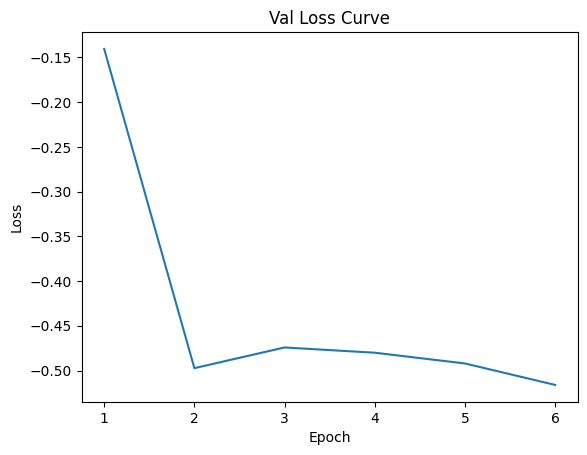

Student weights and architecture saved and exported for lambda: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 1/100*****
*****Train Loss:  0.634575 Val Loss:  0.273218*****
*****Validation Accuracy: 61.24%*****
*****Total Avg Disparity: 0.16940851350258682*****

Class Team_Sports: Recall Difference = 0.08581771471944888
Class Celebration: Recall Difference = 0.01430159692743077
Class Parade: Recall Difference = 0.07409353652128203
Class Waiter_Or_Waitress: Recall Difference = -0.24489795918367352
Class Individual_Sports: Recall Difference = -0.12222953697608063
Class Surgeons: Recall Difference = -0.04508499630450846
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.13451924194861076
Class Business: Recall Difference = 0.0598891730605286
Class Dresses: Recall Difference = -0.7361963190184049
Class Water Activities: Recall Difference = -0.004296698326549109
Class Picnic: Recall Difference = -0.2941176470588235
Class Rescue: Recall Difference = 0.09240506329113918
Class Cheering: Recall Difference = -0.0630114566284779
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.36it/s]


*****Epoch 2/100*****
*****Train Loss:  0.375729 Val Loss:  0.268827*****
*****Validation Accuracy: 62.60%*****
*****Total Avg Disparity: 0.1518606637060661*****

Class Team_Sports: Recall Difference = 0.05057511531499992
Class Celebration: Recall Difference = -0.09101475641803108
Class Parade: Recall Difference = 0.05377474163601337
Class Waiter_Or_Waitress: Recall Difference = -0.23704866562009408
Class Individual_Sports: Recall Difference = -0.22207592714505153
Class Surgeons: Recall Difference = -0.11160384331116058
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.08138588536216718
Class Business: Recall Difference = -0.010017050298380237
Class Dresses: Recall Difference = -0.6914110429447854
Class Water Activities: Recall Difference = 0.011307100859339614
Class Picnic: Recall Difference = -0.0915032679738561
Class Rescue: Recall Difference = 0.06101265822784807
Class Cheering: Recall Difference = 0.05585106382978722
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.39it/s]


*****Epoch 3/100*****
*****Train Loss:  0.246416 Val Loss:  0.289855*****
*****Validation Accuracy: 63.81%*****
*****Total Avg Disparity: 0.14221520943784438*****

Class Team_Sports: Recall Difference = 0.04585741811175359
Class Celebration: Recall Difference = -0.077824944410754
Class Parade: Recall Difference = 0.11035207566999483
Class Waiter_Or_Waitress: Recall Difference = -0.2676609105180533
Class Individual_Sports: Recall Difference = -0.05881062102260237
Class Surgeons: Recall Difference = 0.00960827790096086
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.07871177770026727
Class Business: Recall Difference = 0.07949701619778343
Class Dresses: Recall Difference = -0.7055214723926381
Class Water Activities: Recall Difference = -0.03414744459520569
Class Picnic: Recall Difference = -0.14379084967320266
Class Rescue: Recall Difference = -0.018987341772151944
Class Cheering: Recall Difference = -0.10720130932896887
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.38it/s]


*****Epoch 4/100*****
*****Train Loss:  0.159419 Val Loss:  0.298122*****
*****Validation Accuracy: 64.07%*****
*****Total Avg Disparity: 0.14766534402645637*****

Class Team_Sports: Recall Difference = 0.05809540491621412
Class Celebration: Recall Difference = -0.03355569031736416
Class Parade: Recall Difference = 0.1073159339055294
Class Waiter_Or_Waitress: Recall Difference = -0.25745682888540034
Class Individual_Sports: Recall Difference = -0.08997147245995174
Class Surgeons: Recall Difference = -0.14855875831485593
Class Spa: Recall Difference = -0.120567375886525
Class Law_Enforcement: Recall Difference = 0.13277525869085005
Class Business: Recall Difference = -0.013853367433930064
Class Dresses: Recall Difference = -0.6484662576687116
Class Water Activities: Recall Difference = 0.0030529172320217235
Class Picnic: Recall Difference = -0.2549019607843137
Class Rescue: Recall Difference = 0.14632911392405062
Class Cheering: Recall Difference = -0.07630932896890341
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.37it/s]


*****Epoch 5/100*****
*****Train Loss:  0.120804 Val Loss:  0.309162*****
*****Validation Accuracy: 65.19%*****
*****Total Avg Disparity: 0.16372078482592728*****

Class Team_Sports: Recall Difference = 0.05107724645296896
Class Celebration: Recall Difference = -0.05654942389326867
Class Parade: Recall Difference = 0.11321305540958715
Class Waiter_Or_Waitress: Recall Difference = -0.31397174254317106
Class Individual_Sports: Recall Difference = -0.0932996854655842
Class Surgeons: Recall Difference = -0.06947524020694751
Class Spa: Recall Difference = -0.43262411347517743
Class Law_Enforcement: Recall Difference = 0.1567259620974305
Class Business: Recall Difference = -0.03026427962489353
Class Dresses: Recall Difference = -0.6914110429447853
Class Water Activities: Recall Difference = 0.003505201266395419
Class Picnic: Recall Difference = -0.18300653594771243
Class Rescue: Recall Difference = 0.021012658227848147
Class Cheering: Recall Difference = -0.1421849427168576
Class Performance

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 6/100*****
*****Train Loss:  0.095780 Val Loss:  0.299490*****
*****Validation Accuracy: 66.32%*****
*****Total Avg Disparity: 0.1424703233465565*****

Class Team_Sports: Recall Difference = 0.04411747533134813
Class Celebration: Recall Difference = -0.0448756822316555
Class Parade: Recall Difference = 0.04379050621825187
Class Waiter_Or_Waitress: Recall Difference = -0.37284144427001586
Class Individual_Sports: Recall Difference = -0.02600394996708366
Class Surgeons: Recall Difference = -0.02734663710273455
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.008719916288803753
Class Business: Recall Difference = -0.0008525149190111714
Class Dresses: Recall Difference = -0.7300613496932515
Class Water Activities: Recall Difference = 0.0032790592492085713
Class Picnic: Recall Difference = -0.15032679738562094
Class Rescue: Recall Difference = 0.10227848101265818
Class Cheering: Recall Difference = -0.13154664484451717
Class Performa

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 7/100*****
*****Train Loss:  0.078179 Val Loss:  0.277943*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.16492186005038986*****

Class Team_Sports: Recall Difference = 0.0690371927366148
Class Celebration: Recall Difference = -0.006670709520921747
Class Parade: Recall Difference = 0.03941145559642656
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.021029917343281412
Class Surgeons: Recall Difference = -0.09977827050997778
Class Spa: Recall Difference = -0.49645390070921974
Class Law_Enforcement: Recall Difference = 0.11242878735030826
Class Business: Recall Difference = 0.03388746803069054
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.01843057440072382
Class Picnic: Recall Difference = -0.40522875816993476
Class Rescue: Recall Difference = 0.07898734177215183
Class Cheering: Recall Difference = -0.04398527004909997
Class Performanc

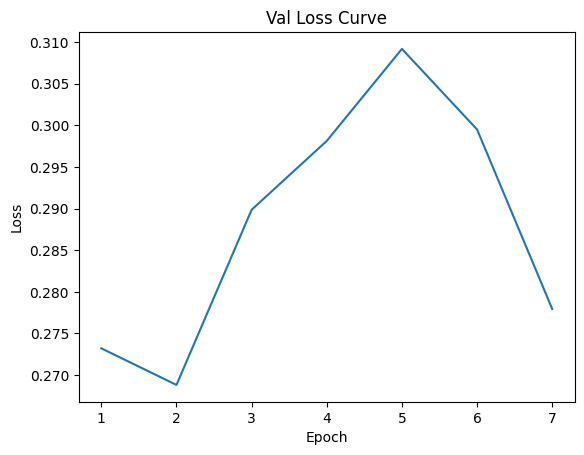

Student weights and architecture saved and exported for lambda: 0


In [22]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    if i != 0:
        pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
        pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, 
                                                                               adv_criterion, student_optimizer, student_optimizer_adv, device, alpha, 
                                                                               temperature, epochs, lmda=i, patience=patience_student)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [23]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [24]:
# Loop through each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


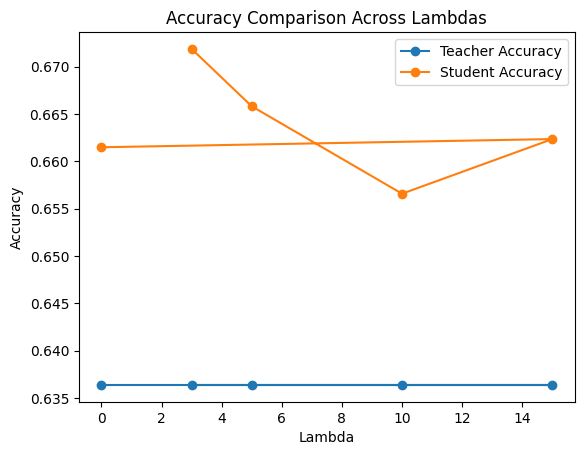

In [25]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


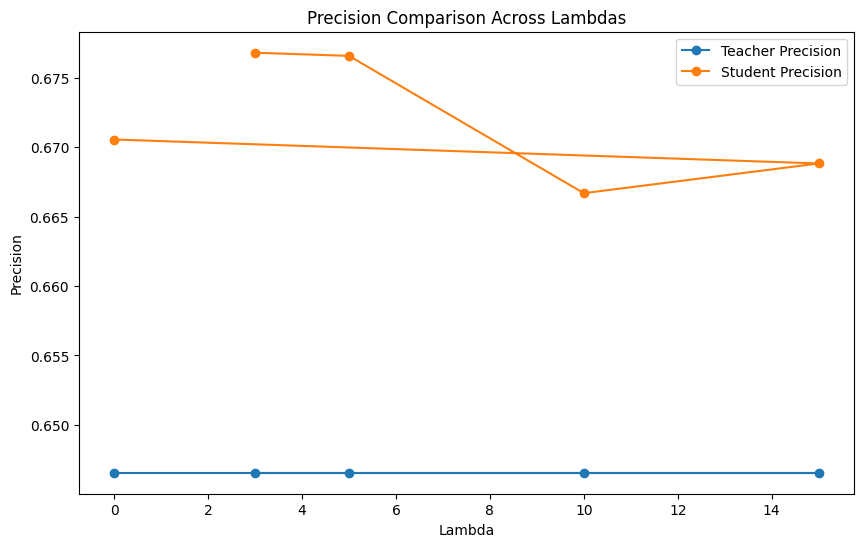

In [26]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


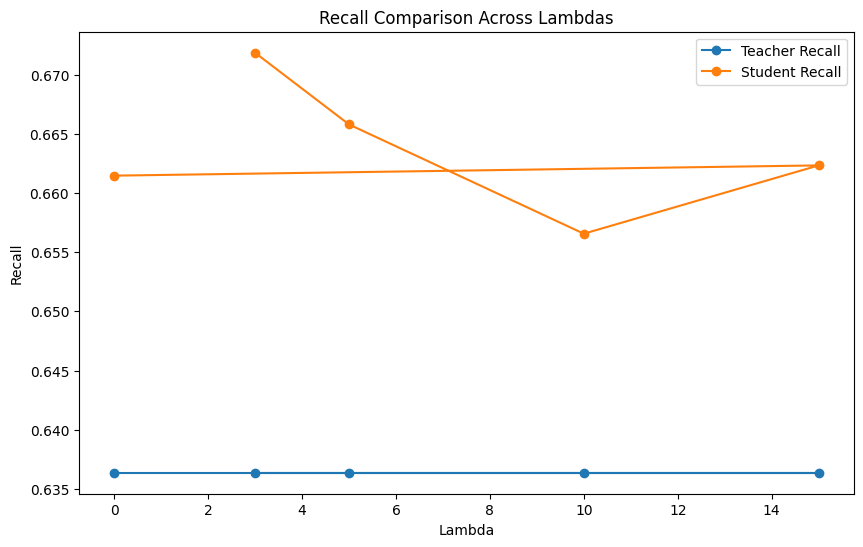

In [27]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


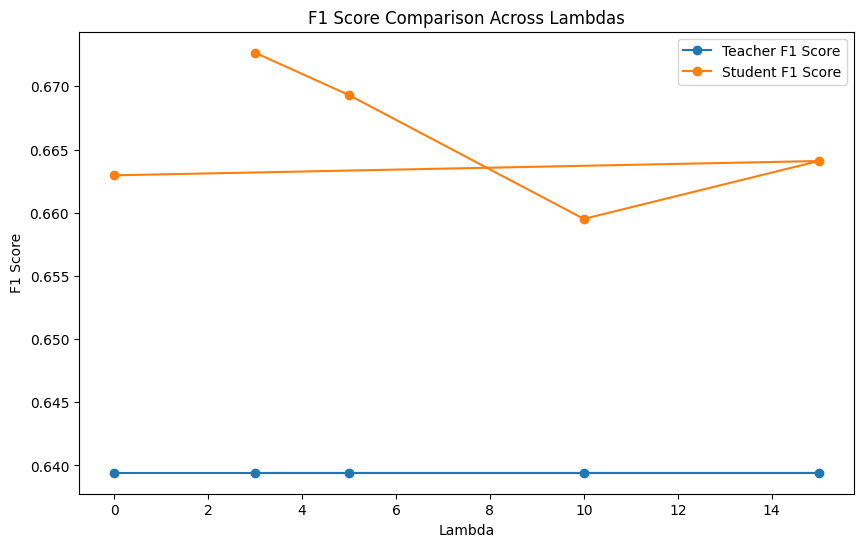

In [28]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


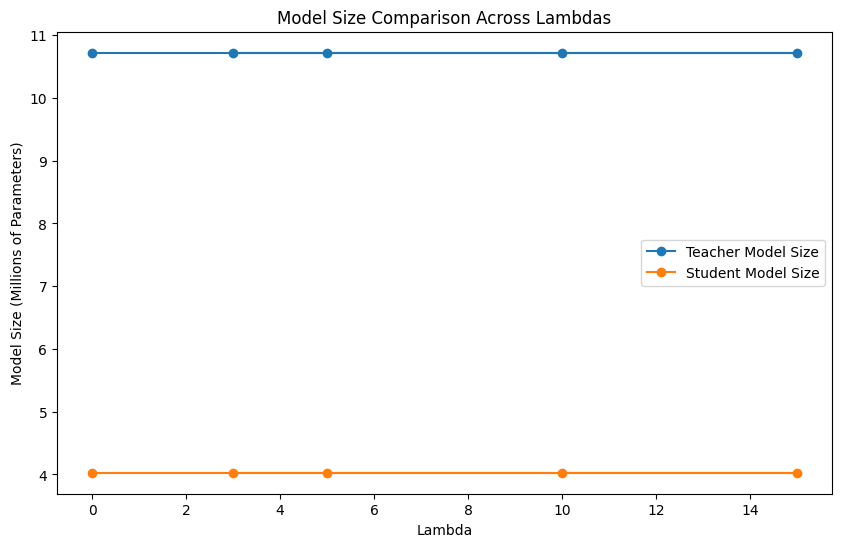

In [29]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


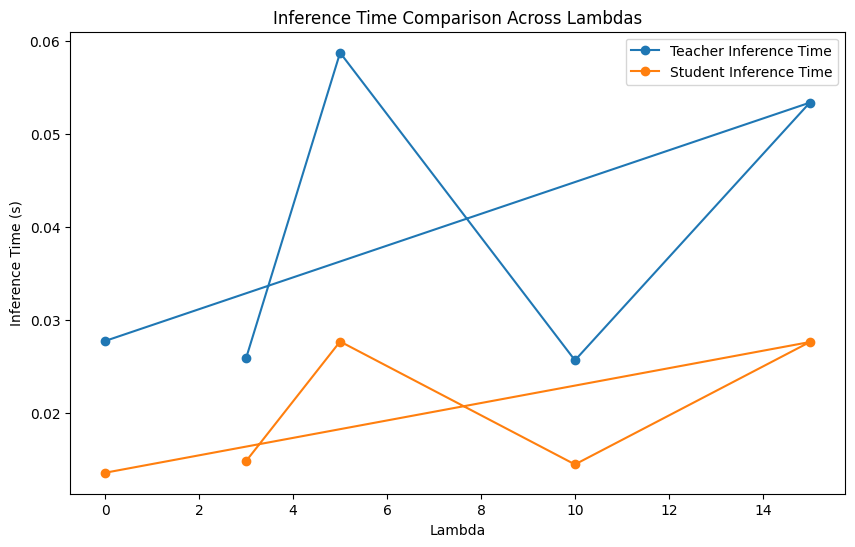

In [30]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


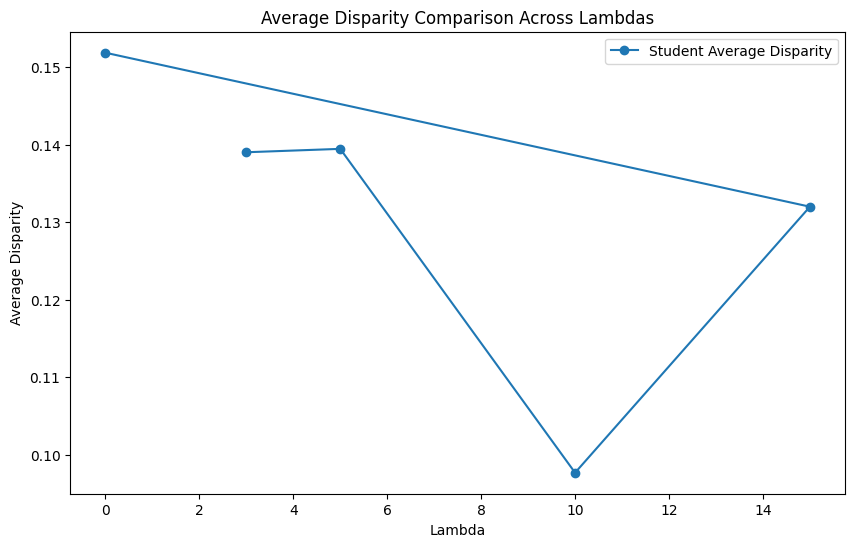

In [31]:
# Extracting disparity values for both teacher and student models
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [32]:
lambda_results

{0: {'teacher_mean_abs_val_disparity': [0.16684844110610364,
   0.13805017304359432,
   0.10985936457812995,
   0.07942519667500281,
   0.11626767060569561],
  'student_mean_abs_val_disparity': 0.1518606637060661,
  'performance_metrics': {'metrics': {'accuracy': (0.6363636363636364,
     0.6614718614718614),
    'precision': (0.6465566964665924, 0.6705523002766982),
    'recall': (0.6363636363636364, 0.6614718614718614),
    'f1': (0.6394245726193358, 0.6629593725190858)},
   'all_labels': array([ 2,  2,  2, ..., 13, 13, 13]),
   'all_teacher_preds': array([ 2,  2,  2, ..., 13, 13, 13]),
   'all_student_preds': array([ 2,  2, 15, ...,  8,  2,  0])},
  'teacher_params': 10720824,
  'student_params': 4028044,
  'teacher_time': 0.027750492095947266,
  'student_time': 0.013594627380371094},
 15: {'student_mean_abs_val_disparity': 0.13198563085996176,
  'performance_metrics': {'metrics': {'accuracy': (0.6363636363636364,
     0.6623376623376623),
    'precision': (0.6465566964665924, 0.668

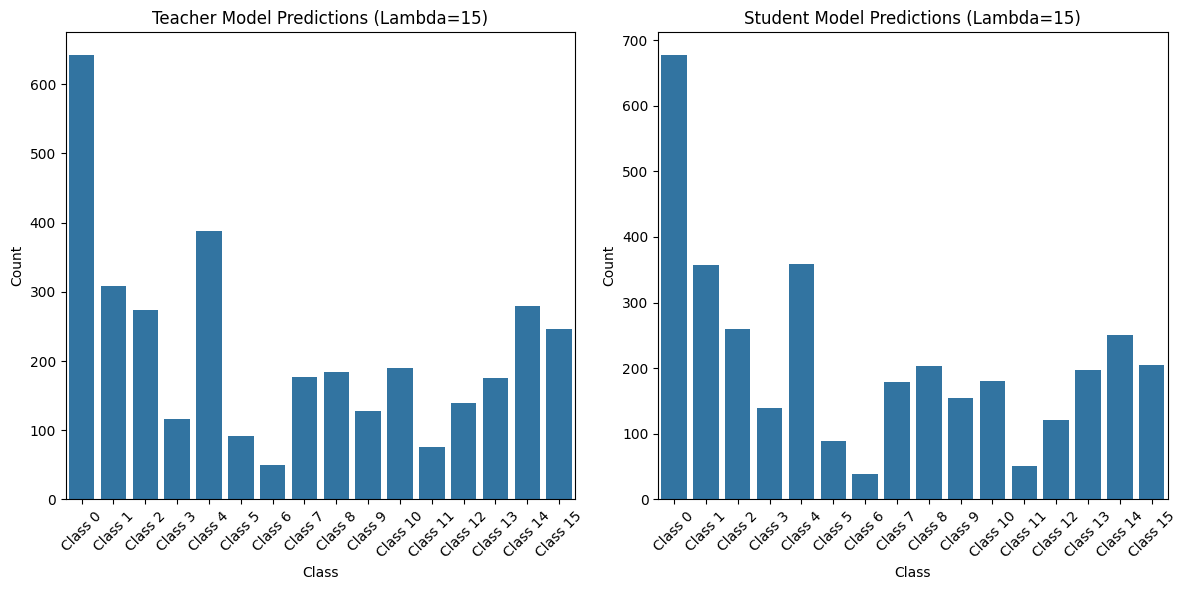

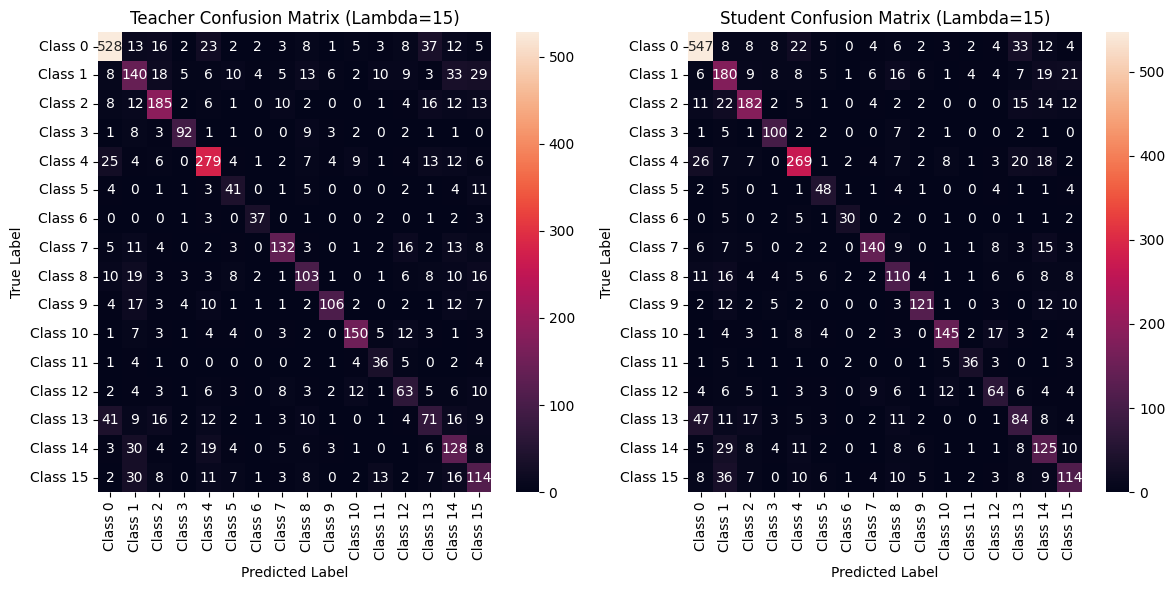

Classification Report - Teacher Model (Lambda=15)
              precision    recall  f1-score   support

     Class 0       0.82      0.79      0.81       668
     Class 1       0.45      0.47      0.46       301
     Class 2       0.68      0.68      0.68       272
     Class 3       0.79      0.74      0.77       124
     Class 4       0.72      0.74      0.73       377
     Class 5       0.45      0.55      0.50        74
     Class 6       0.76      0.74      0.75        50
     Class 7       0.75      0.65      0.70       202
     Class 8       0.56      0.53      0.54       194
     Class 9       0.83      0.61      0.70       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.47      0.60      0.53        60
    Class 12       0.45      0.49      0.47       129
    Class 13       0.41      0.36      0.38       198
    Class 14       0.46      0.58      0.51       220
    Class 15       0.46      0.51      0.49       224

    accuracy                  

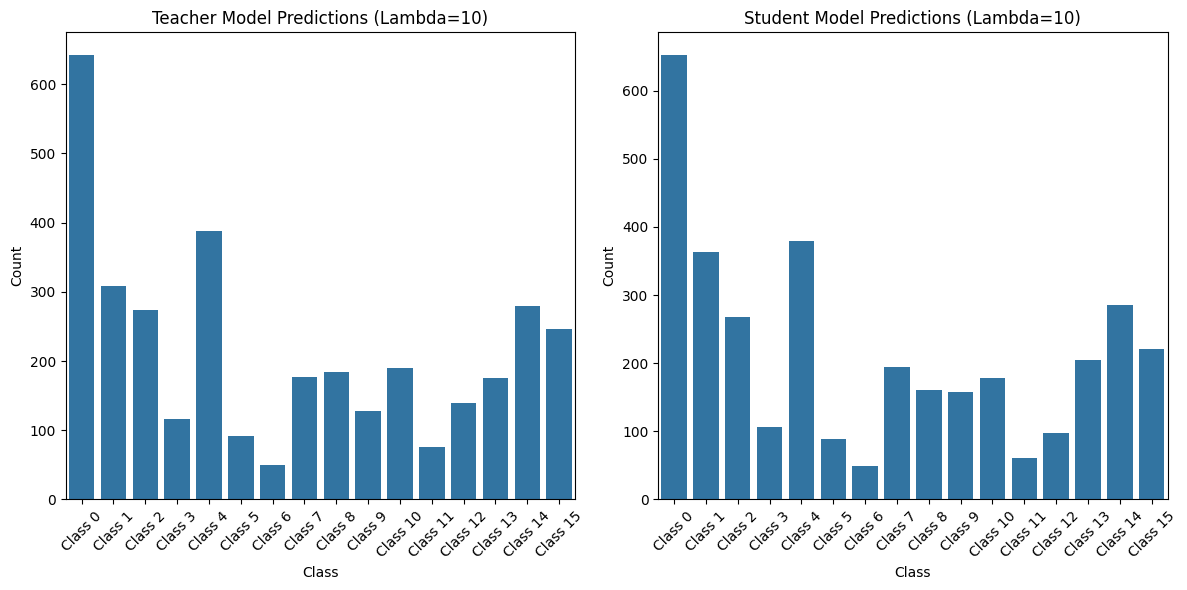

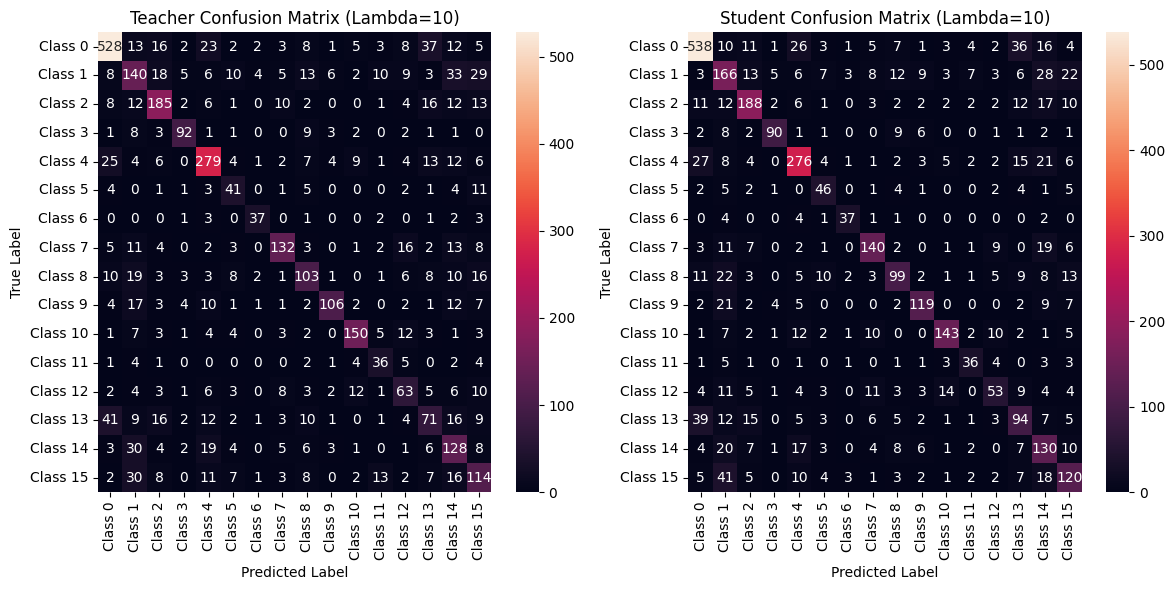

Classification Report - Teacher Model (Lambda=10)
              precision    recall  f1-score   support

     Class 0       0.82      0.79      0.81       668
     Class 1       0.45      0.47      0.46       301
     Class 2       0.68      0.68      0.68       272
     Class 3       0.79      0.74      0.77       124
     Class 4       0.72      0.74      0.73       377
     Class 5       0.45      0.55      0.50        74
     Class 6       0.76      0.74      0.75        50
     Class 7       0.75      0.65      0.70       202
     Class 8       0.56      0.53      0.54       194
     Class 9       0.83      0.61      0.70       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.47      0.60      0.53        60
    Class 12       0.45      0.49      0.47       129
    Class 13       0.41      0.36      0.38       198
    Class 14       0.46      0.58      0.51       220
    Class 15       0.46      0.51      0.49       224

    accuracy                  

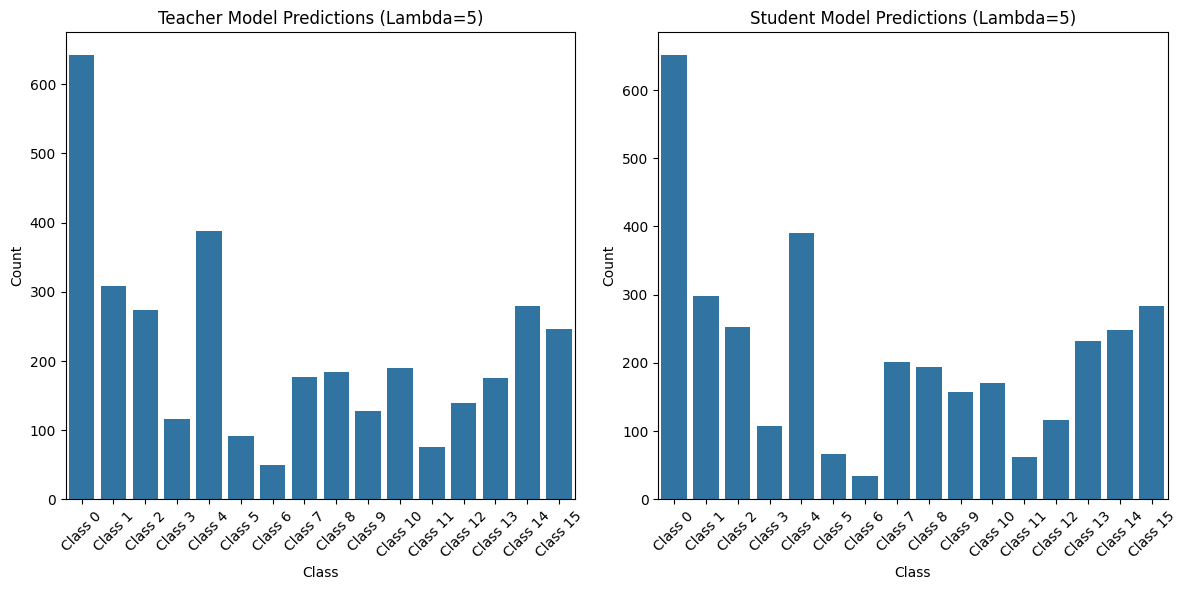

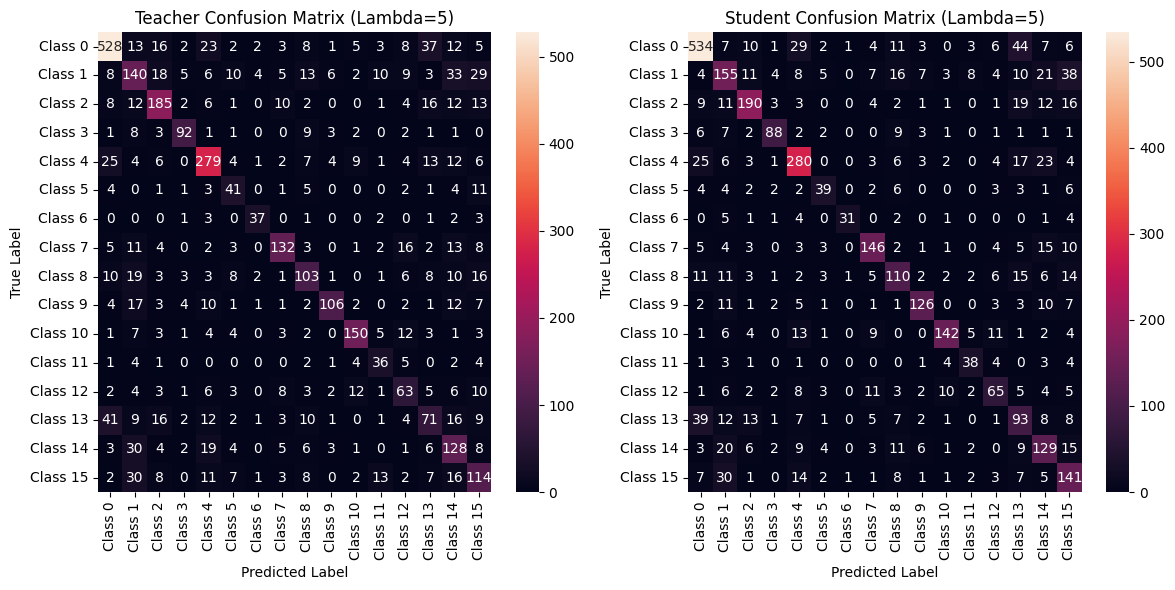

Classification Report - Teacher Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.82      0.79      0.81       668
     Class 1       0.45      0.47      0.46       301
     Class 2       0.68      0.68      0.68       272
     Class 3       0.79      0.74      0.77       124
     Class 4       0.72      0.74      0.73       377
     Class 5       0.45      0.55      0.50        74
     Class 6       0.76      0.74      0.75        50
     Class 7       0.75      0.65      0.70       202
     Class 8       0.56      0.53      0.54       194
     Class 9       0.83      0.61      0.70       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.47      0.60      0.53        60
    Class 12       0.45      0.49      0.47       129
    Class 13       0.41      0.36      0.38       198
    Class 14       0.46      0.58      0.51       220
    Class 15       0.46      0.51      0.49       224

    accuracy                   

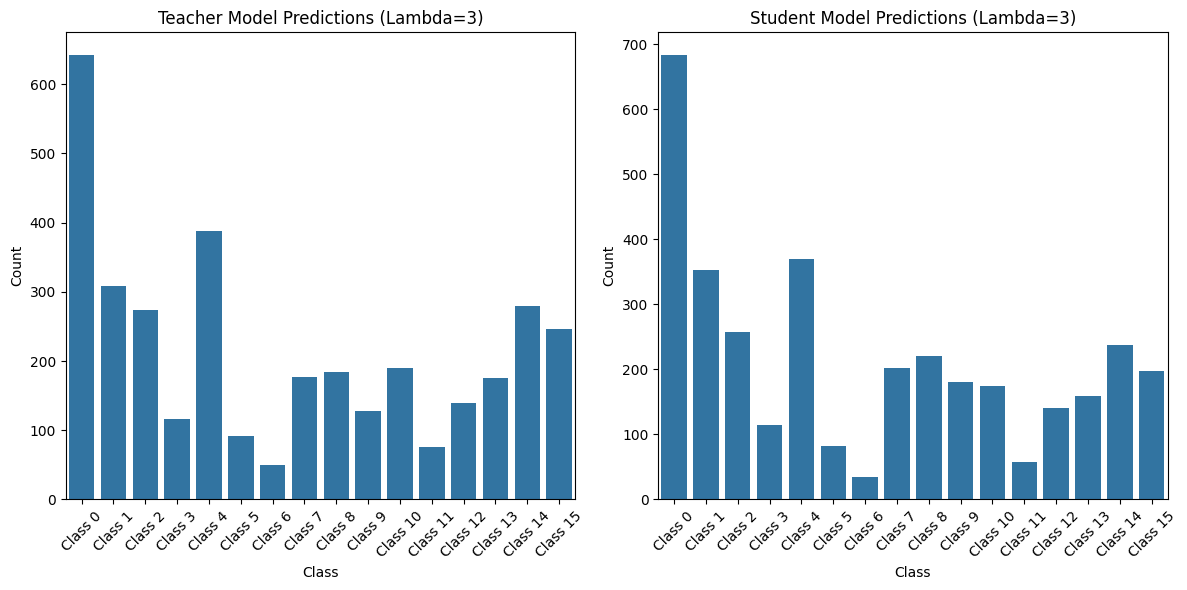

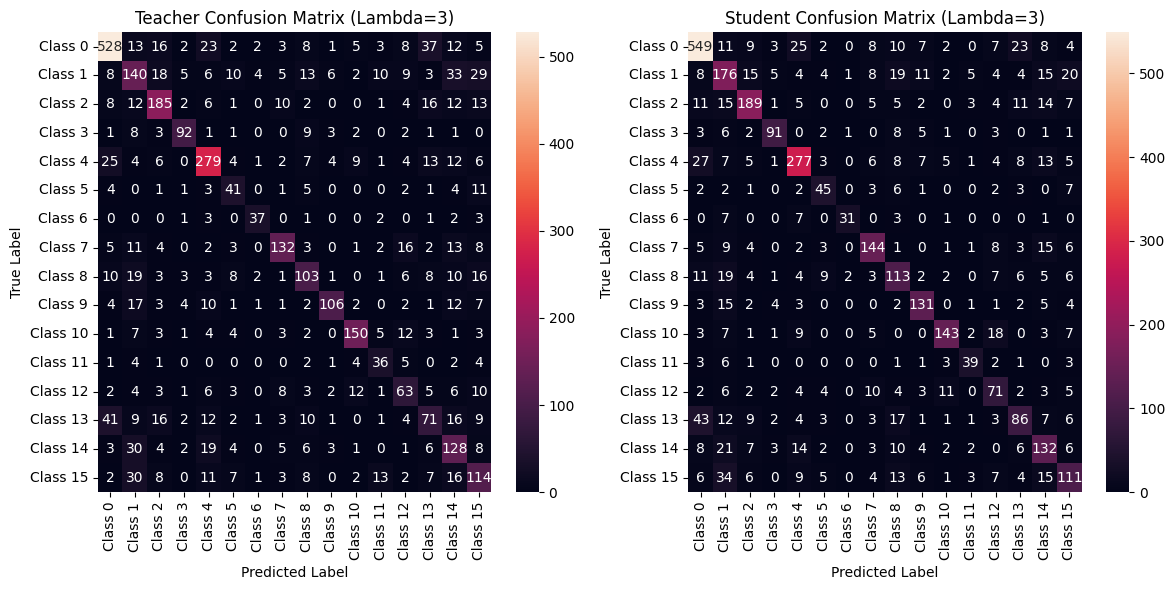

Classification Report - Teacher Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.82      0.79      0.81       668
     Class 1       0.45      0.47      0.46       301
     Class 2       0.68      0.68      0.68       272
     Class 3       0.79      0.74      0.77       124
     Class 4       0.72      0.74      0.73       377
     Class 5       0.45      0.55      0.50        74
     Class 6       0.76      0.74      0.75        50
     Class 7       0.75      0.65      0.70       202
     Class 8       0.56      0.53      0.54       194
     Class 9       0.83      0.61      0.70       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.47      0.60      0.53        60
    Class 12       0.45      0.49      0.47       129
    Class 13       0.41      0.36      0.38       198
    Class 14       0.46      0.58      0.51       220
    Class 15       0.46      0.51      0.49       224

    accuracy                   

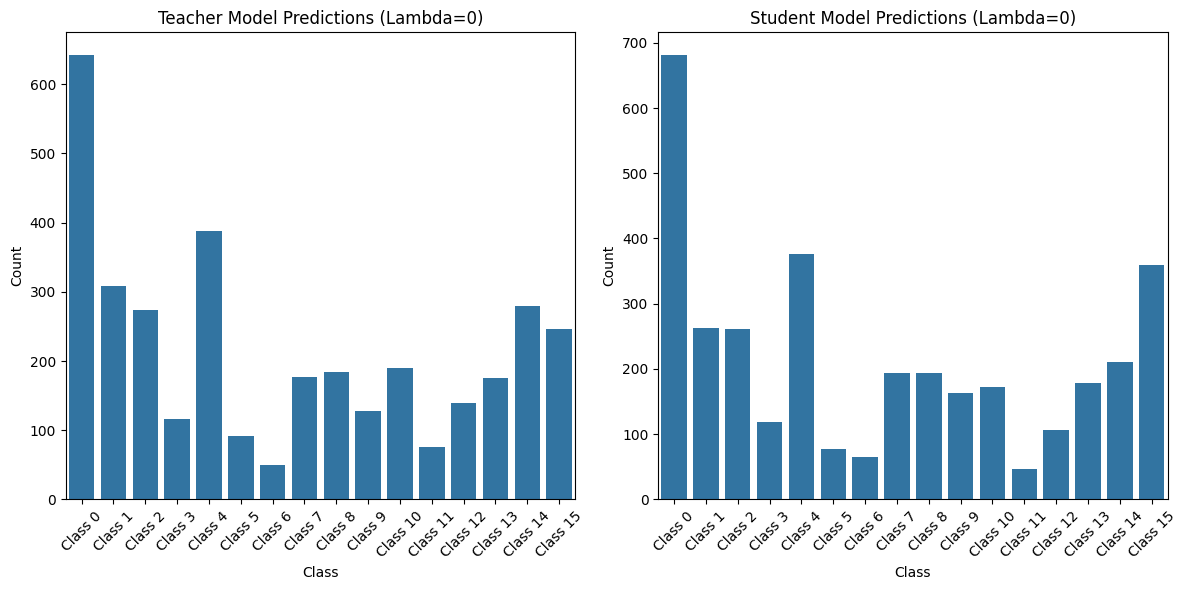

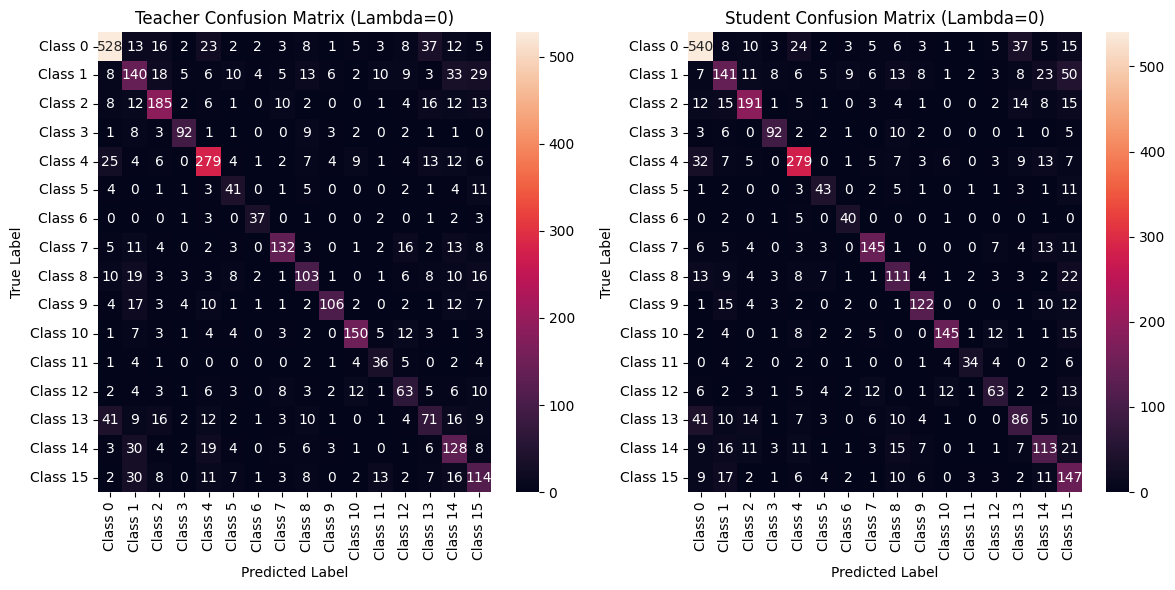

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.82      0.79      0.81       668
     Class 1       0.45      0.47      0.46       301
     Class 2       0.68      0.68      0.68       272
     Class 3       0.79      0.74      0.77       124
     Class 4       0.72      0.74      0.73       377
     Class 5       0.45      0.55      0.50        74
     Class 6       0.76      0.74      0.75        50
     Class 7       0.75      0.65      0.70       202
     Class 8       0.56      0.53      0.54       194
     Class 9       0.83      0.61      0.70       173
    Class 10       0.79      0.75      0.77       199
    Class 11       0.47      0.60      0.53        60
    Class 12       0.45      0.49      0.47       129
    Class 13       0.41      0.36      0.38       198
    Class 14       0.46      0.58      0.51       220
    Class 15       0.46      0.51      0.49       224

    accuracy                   

In [33]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


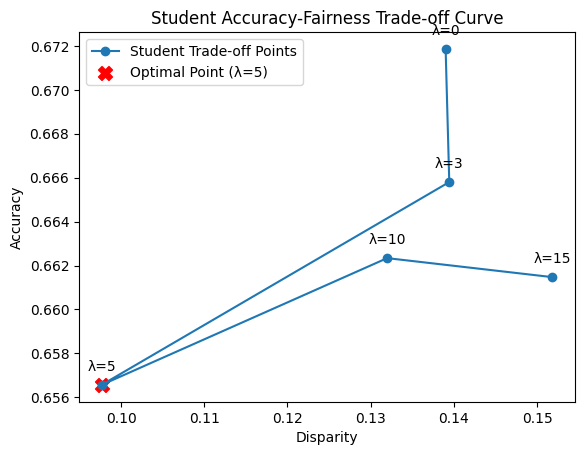

Optimal Lambda for Student: 5
Optimal Bias/Disparity for Student: 0.09764947074588264
Optimal Accuracy for Student: 0.6565656565656566
Optimal Weighted Ratio for Student: 0.60


In [34]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
# plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)


In [35]:
def get_disparities_accuracies_student(lmda, dataloader):
    model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [36]:
for i in lmda_list_student:
    get_disparities_accuracies(i, testloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.66it/s]


Lambda: 15*****Validation Accuracy: 66.23%*****
*****Total Avg Disparity: 0.1507543989591668*****

Class Team_Sports: Recall Difference = 0.020774216149938796
Class Celebration: Recall Difference = -0.00010107135637760223
Class Parade: Recall Difference = 0.012027792374613155
Class Waiter_Or_Waitress: Recall Difference = -0.2904238618524332
Class Individual_Sports: Recall Difference = -0.01276424548313948
Class Surgeons: Recall Difference = -0.0325203252032521
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.1239390768515286
Class Business: Recall Difference = -0.037936913895993074
Class Dresses: Recall Difference = -0.7423312883435583
Class Water Activities: Recall Difference = -0.02657168701944812
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = 0.12430379746835457
Class Cheering: Recall Difference = -0.10372340425531912
Class Performance_And_Entertainment: Recall Difference = 0.029550827423167614

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.70it/s]


Lambda: 10*****Validation Accuracy: 65.66%*****
*****Total Avg Disparity: 0.12036063526932429*****

Class Team_Sports: Recall Difference = 0.018193495650142943
Class Celebration: Recall Difference = -0.053163533454618994
Class Parade: Recall Difference = 0.040871139137034995
Class Waiter_Or_Waitress: Recall Difference = -0.18838304552590257
Class Individual_Sports: Recall Difference = -0.03785385121790641
Class Surgeons: Recall Difference = -0.1359940872135995
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.14742471805603985
Class Business: Recall Difference = -0.021739130434782594
Class Dresses: Recall Difference = -0.6239263803680981
Class Water Activities: Recall Difference = -0.0192220714608774
Class Picnic: Recall Difference = -0.31372549019607837
Class Rescue: Recall Difference = 0.0177215189873417
Class Cheering: Recall Difference = -0.06833060556464815
Class Performance_And_Entertainment: Recall Difference = 0.008443093549476477


100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.66it/s]


Lambda: 5*****Validation Accuracy: 66.58%*****
*****Total Avg Disparity: 0.1388258764059656*****

Class Team_Sports: Recall Difference = 0.033514334092368814
Class Celebration: Recall Difference = -0.01445320396199723
Class Parade: Recall Difference = 0.04519180241723597
Class Waiter_Or_Waitress: Recall Difference = -0.26530612244897955
Class Individual_Sports: Recall Difference = -0.010825835710628118
Class Surgeons: Recall Difference = -0.03325942350332589
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.07254970352284595
Class Business: Recall Difference = -0.058610400682011954
Class Dresses: Recall Difference = -0.7730061349693251
Class Water Activities: Recall Difference = -0.0718000904568068
Class Picnic: Recall Difference = -0.22222222222222227
Class Rescue: Recall Difference = 0.07164556962025309
Class Cheering: Recall Difference = -0.11845335515548283
Class Performance_And_Entertainment: Recall Difference = -0.0021952043228640195

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.66it/s]


Lambda: 3*****Validation Accuracy: 67.19%*****
*****Total Avg Disparity: 0.14132608597857726*****

Class Team_Sports: Recall Difference = 0.04821626671337642
Class Celebration: Recall Difference = -0.0717606630280978
Class Parade: Recall Difference = 0.035090792316225694
Class Waiter_Or_Waitress: Recall Difference = -0.3445839874411304
Class Individual_Sports: Recall Difference = -0.09659132470192378
Class Surgeons: Recall Difference = 0.05838876570583895
Class Spa: Recall Difference = -0.30496453900709214
Class Law_Enforcement: Recall Difference = 0.1288222299732591
Class Business: Recall Difference = 0.012148337595907943
Class Dresses: Recall Difference = -0.6975460122699386
Class Water Activities: Recall Difference = 0.0032790592492085713
Class Picnic: Recall Difference = -0.2418300653594771
Class Rescue: Recall Difference = -0.01569620253164561
Class Cheering: Recall Difference = -0.02373158756137489
Class Performance_And_Entertainment: Recall Difference = -0.026004728132387855
Cla

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.68it/s]

Lambda: 0*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.16492186005038986*****

Class Team_Sports: Recall Difference = 0.0690371927366148
Class Celebration: Recall Difference = -0.006670709520921747
Class Parade: Recall Difference = 0.03941145559642656
Class Waiter_Or_Waitress: Recall Difference = -0.30612244897959184
Class Individual_Sports: Recall Difference = -0.021029917343281412
Class Surgeons: Recall Difference = -0.09977827050997778
Class Spa: Recall Difference = -0.49645390070921974
Class Law_Enforcement: Recall Difference = 0.11242878735030826
Class Business: Recall Difference = 0.03388746803069054
Class Dresses: Recall Difference = -0.7484662576687117
Class Water Activities: Recall Difference = 0.01843057440072382
Class Picnic: Recall Difference = -0.40522875816993476
Class Rescue: Recall Difference = 0.07898734177215183
Class Cheering: Recall Difference = -0.04398527004909997
Class Performance_And_Entertainment: Recall Difference = 0.050489699425869616
Cla

In [38]:
def get_disparities_accuracies_teacher(lmda, dataloader):
    model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    total_samples = 0
    total_correct = 0
    num_batches = 0.0
    confusion_male = 0
    confusion_female = 0
    val_accuracies = []
    val_disparities = []
    with torch.no_grad():
        for val_data in tqdm(testloader):
            val_inputs = val_data['img'].to(device)
            val_labels = val_data['label'].to(device)
            val_targets = val_data['target'].to(device)

            # Forward pass for validation
            val_student_outputs = model(val_inputs)   


            # Compute the validation accuracy
            _, predicted = torch.max(val_student_outputs, 1)
            total_samples += val_labels.size(0)
            total_correct += (predicted == val_labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        confusion_male  = confusion_male/num_batches
        confusion_female = confusion_female/num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'Lambda: {lmda}'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}

        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")

In [39]:
get_disparities_accuracies_teacher(0, testloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.52it/s]

Lambda: 0*****Validation Accuracy: 63.64%*****
*****Total Avg Disparity: 0.11626767060569561*****

Class Team_Sports: Recall Difference = 0.03699421965317917
Class Celebration: Recall Difference = -0.032191227006266365
Class Parade: Recall Difference = 0.04233082267764354
Class Waiter_Or_Waitress: Recall Difference = -0.20879120879120894
Class Individual_Sports: Recall Difference = -0.13133640552995374
Class Surgeons: Recall Difference = -0.14855875831485588
Class Spa: Recall Difference = -0.07801418439716334
Class Law_Enforcement: Recall Difference = 0.06720148819904648
Class Business: Recall Difference = -0.0652173913043479
Class Dresses: Recall Difference = -0.4380368098159508
Class Water Activities: Recall Difference = -0.011194029850746245
Class Picnic: Recall Difference = -0.4444444444444444
Class Rescue: Recall Difference = 0.013670886075949351
Class Cheering: Recall Difference = -0.08694762684124385
Class Performance_And_Entertainment: Recall Difference = 0.0428909152313407
Cla